In [ ]:
#!git clone https://github.com/rwightman/efficientdet-pytorch.git
#!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1-4c7ebaf2.pth
#!mv tf_efficientdet_d1-4c7ebaf2.pth tf_efficientdet_d1.pth

In [ ]:
#!pip install timm
#!pip install omegaconf
#!pip install tensorboard

### [apex](https://github.com/NVIDIA/apex)


In [ ]:
#!git clone https://github.com/NVIDIA/apex
#!cd apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [1]:
%cd ../

/home/ubuntu/ballod/efficientdet-pytorch


### config

In [2]:
import os
import sys
import time
from datetime import datetime
import argparse
import torch
import torchvision.utils
from tqdm import tqdm
from pycocotools.coco import COCO

sys.path.append(os.path.join('./efficientdet-pytorch'))
sys.path.append(os.path.join('./apex'))


try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    from apex.parallel import convert_syncbn_model
    from apex.optimizers import FusedSGD #,FusedNovoGrad, FusedAdam, FusedLAMB
    has_apex = True
except ImportError:
    from torch.nn.parallel import DistributedDataParallel as DDP
    has_apex = False


#has_apex = False
print("Using apex:", has_apex)

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, COCOEvaluator, unwrap_bench
from effdet.efficientdet import HeadNet
from data import transforms as efdetTF
from data import create_loader, CocoDetection

from timm.models import resume_checkpoint, load_checkpoint
from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler, CosineLRScheduler

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./output/t1/logs")

torch.backends.cudnn.benchmark = True

Using apex: True


In [3]:
# 設定
img_size = 640
BatchSize = 20
setup_default_logging()

## ローダーの設定

In [4]:
#dataset_train = CocoDetection('../../ballod_dataset/', "./annotations/train_ball_coco.json")
dataset_train = CocoDetection("../", "../annotations/train_ball_coco.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
loader_train = create_loader(dataset_train, batch_size=BatchSize, input_size=img_size, is_training=True, use_prefetcher=True,
                            interpolation="random", num_workers=1, distributed=False, pin_mem=False)

(640, 640, 3)
{'img_id': 109, 'bbox': array([[  88.12982 , 1562.96    ,   98.246155, 1574.5215  ]],
      dtype=float32), 'cls': array([1]), 'img_size': (1920, 1080), 'img_scale': 0.6919503922480525}


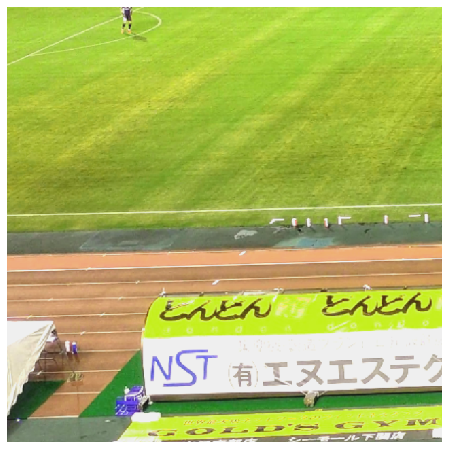

In [6]:
import matplotlib.pyplot as plt
import cv2
print(loader_train)
img, target = dataset_train[100]
img = img.transpose(1,2,0)
print(img.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print(target)
boxes = target['bbox']
for box in boxes:
    cv2.rectangle(img, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(img);

In [7]:
dataset_eval = CocoDetection("../", "../annotations/val_ball_coco.json")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [8]:
loader_eval = create_loader(dataset_eval, batch_size=BatchSize, input_size=img_size, is_training=False, use_prefetcher=True,
                            interpolation="", num_workers=1, distributed=False, pin_mem=False)

In [9]:
evaluator = COCOEvaluator(dataset_eval.coco, distributed=False)

## モデルの設定

In [10]:
model_name = "tf_efficientdet_d1"
pretrained = True
prefetcher = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
!ls

LICENSE		      effdet			  sotabench.py
README.md	      notebook			  sotabench_setup.sh
apex		      output			  tf_efficientdet_d1.pth
avg_checkpoints.py    requirements-sotabench.txt  train.py
data		      requirements.txt		  validate.py
distributed_train.sh  setup.py


In [12]:
# model load
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('./tf_efficientdet_d1.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = img_size
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)
model = get_net()

In [13]:
model.to(device)
print("Cuda use")

Cuda use


In [14]:
warmup_learning_rate = 1e-5
learning_rate = 1e-5 * 4
learning_rate_min = 1e-9

In [15]:
parameters = model.parameters()
use_amp = False
if has_apex:
    optimizer = FusedSGD(parameters, lr=learning_rate, momentum=0.9, weight_decay=4e-5, nesterov=True)
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    use_amp = True
else:
    optimizer = torch.optim.AdamW(parameters, lr=0.04)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [16]:
#model_ema = ModelEma(model, decay=0.9998)


In [17]:
eval_metric = "loss"

exp_name = '-'.join([datetime.now().strftime("%Y%m%d-%H%M%S"), model_name])
output_dir = get_outdir("./output/t1", 'train', exp_name)
decreasing = True if eval_metric == 'loss' else False
saver = CheckpointSaver(checkpoint_dir=output_dir, decreasing=decreasing)

## スケジューラ

In [18]:
epochs = 50
warmup_epochs = 5
cooldown_epochs = 10
num_epochs = epochs
noise_range = None
lr_scheduler = CosineLRScheduler(
            optimizer,
            t_initial=num_epochs,
            t_mul=1.0,
            lr_min=learning_rate_min,
            decay_rate=0.1,
            warmup_lr_init=warmup_learning_rate,
            warmup_t=warmup_epochs,
            cycle_limit=1,
            t_in_epochs=True,
            noise_range_t=noise_range,
            noise_pct=0.67,
            noise_std=1.0,
            noise_seed=42,
        )
num_epochs = lr_scheduler.get_cycle_length() + cooldown_epochs
start_epoch = 0

# train

In [19]:
def train_epoch(epoch, model, loader, optimizer,  lr_scheduler=None, saver=None, output_dir='', use_amp=False, model_ema=None):
    """
    if args.prefetcher and args.mixup > 0 and loader.mixup_enabled:
        if args.mixup_off_epoch and epoch >= args.mixup_off_epoch:
            loader.mixup_enabled = False
    """
    
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()

    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    for batch_idx, (input, target) in enumerate(loader):
        #print(input, target)
        last_batch = batch_idx == last_idx
        data_time_m.update(time.time() - end)

        output = model(input, target)
        loss = output['loss']
        
        losses_m.update(loss.item(), input.size(0))
        #print(loss)
        #print(target)
        
        optimizer.zero_grad()
        clip_grad = 10
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), clip_grad)
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)
        num_updates += 1

        batch_time_m.update(time.time() - end)
        if last_batch or batch_idx % 50 == 0:
            lrl = [param_group['lr'] for param_group in optimizer.param_groups]
            lr = sum(lrl) / len(lrl)


            if True:
                logging.info(
                    'Train: {} [{:>4d}/{} ({:>3.0f}%)]  '
                    'Loss: {loss.val:>9.6f} ({loss.avg:>6.4f})  '
                    'Time: {batch_time.val:.3f}s, {rate:>7.2f}/s  '
                    '({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    'LR: {lr:.3e}  '
                    'Data: {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                        epoch,
                        batch_idx, len(loader),
                        100. * batch_idx / last_idx,
                        loss=losses_m,
                        batch_time=batch_time_m,
                        rate=input.size(0) * 1 / batch_time_m.val,
                        rate_avg=input.size(0) * 1 / batch_time_m.avg,
                        lr=lr,
                        data_time=data_time_m))

        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)

        end = time.time()
        # end for

    if hasattr(optimizer, 'sync_lookahead'):
        optimizer.sync_lookahead()

    return OrderedDict([('loss', losses_m.avg)])

In [20]:
a = OrderedDict([('loss', 1)])
print(a)
print(a['loss'])

OrderedDict([('loss', 1)])
1


In [21]:
def validate(model, loader, evaluator=None, log_suffix=''):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx

            output = model(input, target)
            loss = output['loss']
          

            if evaluator is not None:
                #detect = output['detections'].to('cpu').type(torch.int32)
                #target['bbox'].to('cpu').type(torch.int32)
                evaluator.add_predictions(output['detections'], target)
                
      
            reduced_loss = loss.data

            torch.cuda.synchronize()

            losses_m.update(reduced_loss.item(), input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()
            if True and (last_batch or batch_idx % 50 == 0):
                log_name = 'Test' + log_suffix
                logging.info(
                    '{0}: [{1:>4d}/{2}]  '
                    'Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                    'Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  '.format(
                        log_name, batch_idx, last_idx, batch_time=batch_time_m, loss=losses_m))
            
    metrics = OrderedDict([('loss', losses_m.avg)])
    if evaluator is not None:
        metrics['map'] = evaluator.evaluate()

    return metrics

In [ ]:
best_metric = None
best_epoch = None
save_metric = None
try:
    for epoch in range(start_epoch, num_epochs):
        train_metrics = train_epoch(epoch, model, loader_train, optimizer,  lr_scheduler=lr_scheduler, saver=saver, output_dir=output_dir, use_amp=use_amp)
        
        writer.add_scalar("train_loss", train_metrics["loss"], epoch)
        
        eval_metrics = validate(model, loader_eval) # evaluator)
        
        writer.add_scalar("eval_loss", eval_metrics["loss"], epoch)
        #writer.add_scalar("eval", eval_metrics["map"], epoch)
        
        if lr_scheduler is not None:
            # step LR for next epoch
            lr_scheduler.step(epoch + 1, eval_metrics[eval_metric])

        if saver is not None:
            update_summary(
                epoch, train_metrics, eval_metrics, os.path.join(output_dir, 'summary.csv'),
                write_header=best_metric is None
            )

            # save proper checkpoint with eval metric
            class ArgPars():
                def __init__(self):
                    self.model = model_name
            args = ArgPars()
            save_metric = eval_metrics[eval_metric]
            best_metric, best_epoch = saver.save_checkpoint(unwrap_bench(model), optimizer, args, epoch=epoch, metric=save_metric, use_amp=use_amp)
except KeyboardInterrupt:
    pass
if best_metric is not None:
    logging.info('*** Best metric: {0} (epoch {1})'.format(best_metric, best_epoch))

writer.close()


Train: 0 [   0/141 (  0%)]  Loss: 10540.450195 (10540.4502)  Time: 19.570s,    1.02/s  (19.570s,    1.02/s)  LR: 1.000e-05  Data: 11.490 (11.490)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0


Train: 0 [  50/141 ( 36%)]  Loss: 9370.636719 (9574.4484)  Time: 5.587s,    3.58/s  (5.878s,    3.40/s)  LR: 1.000e-05  Data: 5.058 (5.194)
Train: 0 [ 100/141 ( 71%)]  Loss: 10291.516602 (9480.2318)  Time: 6.069s,    3.30/s  (5.819s,    3.44/s)  LR: 1.000e-05  Data: 5.539 (5.210)
Train: 0 [ 140/141 (100%)]  Loss: 8281.866211 (9427.6604)  Time: 6.565s,    1.83/s  (5.821s,    2.06/s)  LR: 1.000e-05  Data: 0.025 (5.191)
Test: [   0/15]  Time: 3.555 (3.555)  Loss: 6863.6890 (6863.6890)  
Test: [  15/15]  Time: 2.116 (1.684)  Loss: 6778.0327 (6858.7954)  
Current checkpoints:
 ('./output/t1/train/20200925-022811-tf_efficientdet_d1/checkpoint-0.pth.tar', 6858.7954319963055)

Train: 1 [   0/141 (  0%)]  Loss: 8273.001953 (8273.0020)  Time: 12.115s,    1.65/s  (12.115s,    1.65/s)  LR: 1.600e-05  Data: 11.300 (11.300)
Train: 1 [  50/141 ( 36%)]  Loss: 8814.893555 (8614.7943)  Time: 5.791s,    3.45/s  (5.793s,    3.45/s)  LR: 1.600e-05  Data: 5.258 (5.251)
Train: 1 [ 100/141 ( 71%)]  Loss: 8042

In [ ]:
print(1)